<a href="https://colab.research.google.com/github/VladKarad/AI_education/blob/main/Mnist_Autoencoder_architecture_HW_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Создайте автокодировщик, удаляющий черные квадраты в лучшайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [ ]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np 

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam
import random
import copy
# Сохранение и загрузка структур данных Python
import pickle

In [ ]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Отрисовка графиков
import matplotlib.pyplot as plt 

%matplotlib inline

## Данные

In [ ]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [ ]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [ ]:
X_test.shape

(10000, 28, 28, 1)

## Автокодировщик

In [ ]:
###################################################################
###                 МЕСТО ДЛЯ ВАШЕГО ТВОРЧЕСТВА              ###
###################################################################

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_test.shape

(10000, 28, 28, 1)

In [ ]:
# Создание тренировочной базы с произвольными квадратами 8*8
XX_train = None
for s in range(X_train.shape[0]):
  i = random.randint(0,20)
  j = random.randint(0,20)
  XX = X_train[s]
  XX[i:i+8,j:j+8]=0.
  XX = XX.reshape((1, 28, 28, 1))
  XX_train = XX if XX_train is None else np.vstack([XX_train,XX])  
  print(s)

In [ ]:
# Создание тестовой базы с произвольными квадратами 8*8
XX_test = None
for s in range(X_test.shape[0]):
  i = random.randint(0,20)
  j = random.randint(0,20)
  XX = X_test[s]
  XX[i:i+8,j:j+8]=0.
  XX = XX.reshape((1, 28, 28, 1))
  XX_test = XX if XX_test is None else np.vstack([XX_test,XX])  
  print(s)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/sqr.pickle', 'wb') as f:
    pickle.dump((XX_train,XX_test), f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/разное/sqr.pickle', 'wb') as f:
    pickle.dump((XX_train,XX_test), f)

In [ ]:
with open('/content/sqr.pickle', 'rb') as f:
    XX_train,XX_test = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/разное/sqr.pickle', 'rb') as f:
    XX_train,XX_test = pickle.load(f)

In [ ]:
XX_train.shape

(60000, 28, 28, 1)

In [ ]:
XX_test.shape

(10000, 28, 28, 1)

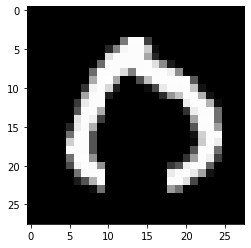

In [ ]:
# Вывод тренировочного примера в черно-белом формате
plt.imshow(XX_train[229].squeeze(axis=-1), cmap='gray')
plt.show()

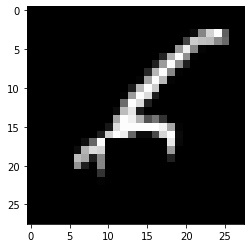

In [ ]:
# Вывод тестового примера в черно-белом формате
plt.imshow(XX_test[1209].squeeze(axis=-1), cmap='gray')
plt.show()

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse')

  return model

In [ ]:
# Создание автокодировщика
ae_mnist = create_base_ae(X_train.shape[1:])

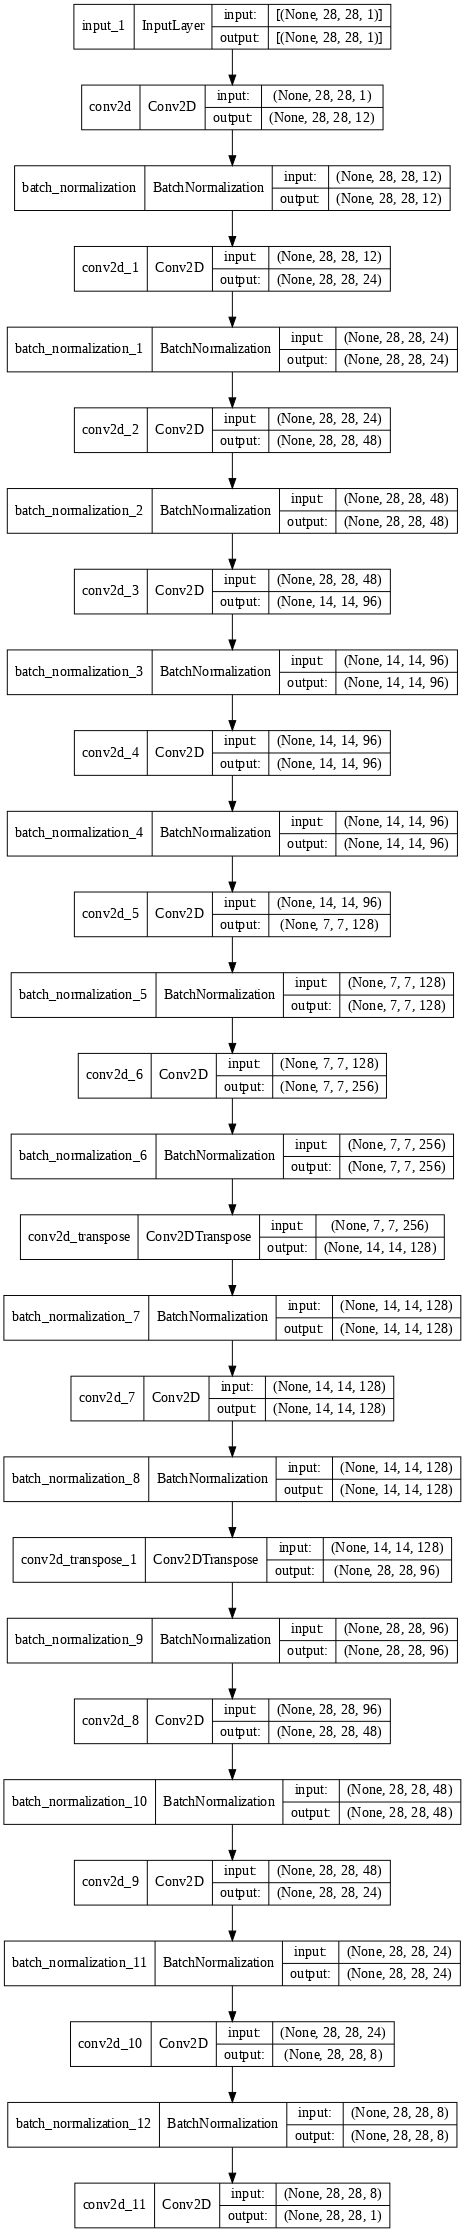

In [ ]:
# Отображение модели
utils.plot_model(ae_mnist, show_shapes=True, dpi=70)

In [ ]:
# Обучение модели на датасете 
ae_mnist.fit(XX_train, X_train,
             epochs=5, 
             batch_size=8,
             validation_data=(XX_test, X_test))

Epoch 1/5
7500/7500 [==============================] - 182s 23ms/step - loss: 0.0153 - val_loss: 0.0050
Epoch 2/5
7500/7500 [==============================] - 169s 22ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/5
7500/7500 [==============================] - 168s 22ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/5
7500/7500 [==============================] - 170s 23ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/5
7500/7500 [==============================] - 167s 22ms/step - loss: 0.0029 - val_loss: 0.0031


In [ ]:
# Сохранение/восстановление модели и выборок
ae_mnist.save('/content/drive/MyDrive/Colab Notebooks/разное/sqr.h5')

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5): 

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
# Получение предсказания автокодировщика на тренировочной, валидационной и тестовой выборках
pred_train_mnist = ae_mnist.predict(XX_train)
pred_test_mnist = ae_mnist.predict(XX_test)

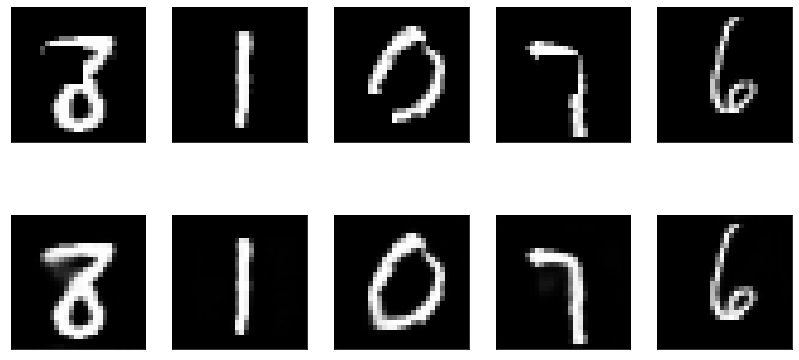

In [ ]:
# Сравнение исходных и восстановленных картинок из валидационной выборки
plot_images(XX_test, pred_test_mnist)

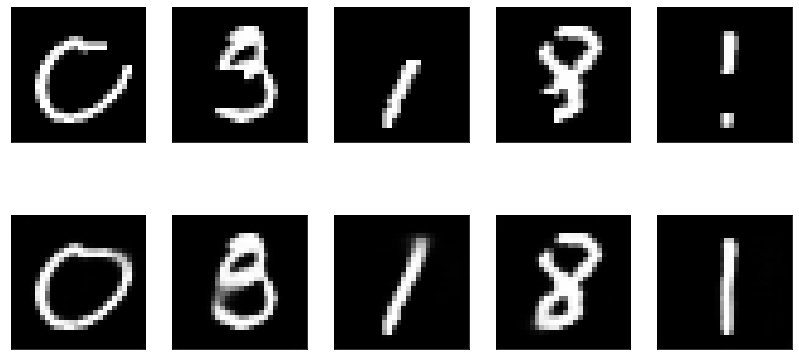

In [ ]:
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(XX_train, pred_train_mnist)